# Processing of particle tracks 
### <font color='gray'>coded to work with experiments and simulation</font>

## _Import of python libraries used within the code_

### <font color ='gray'> load both code cells  </font>  

In [1]:
#HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
# plot display type. use this to keep graphs within the notebook
import matplotlib
%matplotlib notebook 

import matplotlib.pyplot as plt # plot library

import subprocess # these 2 lines below load OS functionality
import sys
import json

from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.stats as st
import scipy.special as spec

import ipywidgets as widgets # import 

from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions

import scipy.optimize as optimize # optimazation library (not used)
from collections import Counter # (not used)
import time # timing functions (for computation time)

from scipy import signal # noise filtering functions

global iscaled 
iscaled = 0

global LX, LY
LX = 1000 -250
LY = 650-50

# system size for a given (npart, rho) configuration
def L(npart, rho):
    l = np.sqrt(npart*2*np.sqrt(3.)/rho)
    return l

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['font.size'] = 24
# special plotting functions
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors


ModuleNotFoundError: No module named 'sympy'

In [54]:
np.max(datos[['x','y']])

x    1000.0
y     650.0
dtype: float64

In [55]:
np.min(datos[['x','y']])

x    250.000476
y     50.000156
dtype: float64

In [2]:
def progreso(val,vmax):

    a= widgets.IntProgress(
        value=val,
        min=0,
        max=vmax,
        step=1,
        description='Loading:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
    return a

In [3]:
progreso(2,104)

## _Read tracking data _ 

We explain the action of each of these functions below:

__get_info(hash_prefix) :__ Reads and prints info file with  _hash prefix_ hash code. See output table in <font color='red' >RUN CELL 0</font> below to grasp the info structure

__simple_pickle_read(hash_prefix) :__
This 'simple_pickle_read' takes a pkl.xz file _hash prefix_ hash code, and which contains xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame.
   
  * input: hash_prefix
  * output: global variable _Ntracks_ (number of tracks) 

In [6]:
def pdisplay(info):
    display(HTML(info.to_html()))

# This function reads pickle binary file (.pkl) with trajectories
def get_info(series_directory, hash_prefix):
    global info
    nombre = './Datos/'+ series_directory +'/info/' + hash_prefix + '_experiment_info.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.json_normalize(jsonstr)
    pdisplay(info.T)
    return info
    
def simple_pickle_read(series_directory, hash_prefix):
    global Nframes, Ntracks
    # Read table in pickle format
    nombre = './Datos/' + series_directory + '/tracks/' + hash_prefix \
       + '_rect_roi_trajectories.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    Nframes = np.max(tabla.frame)+1
    Ntracks = np.max(tabla.track)+1
    print('Number of frames in the movie: ', Nframes)
    print('Maximum track index: ', Ntracks)
    print('\nFirst 5 rows of imported table:\n')
    display(HTML(tabla.head().to_html()))
    tabla = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    return tabla

## _Order experiment series by increasing packing fraction_
_(and for constant packing fraction, order by increasing temperature) _ 

In [6]:
# Read the pickle format table of experiments series
lista_experimentos = pd.read_pickle('./Datos/info_table.pkl', compression='infer')

# order experiments series table by packing fraction (primary) and temperature (secondary)
lista_experimentos_ordenada = lista_experimentos.sort_values(by = ['packing_fraction', 'temperature'])

# Display the complete ordered table; HTML format
#display(HTML(
#        lista_experimentos_ordenada.to_html()
#    ))

# Export pkl table to Excel
#lista_experimentos_ordenada.to_excel('info_table.xlsx')

In [67]:
lista_inf=lista_experimentos_ordenada[lista_experimentos_ordenada.packing_fraction>0.69]

In [68]:
lista_save = lista_inf[lista_inf.packing_fraction<0.99]['experiment_id']

In [69]:
lista_save.to_csv('rho4.dat',index=False)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


In [37]:
lista_save.to_csv('rho1.dat',index=False)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


## _Reduce global table - functions_

__reset_track_indexes(tabla0):__ 
Eliminates 'lonely' tracks (particles tracked for just 1 frame), re-indexes so that no track indexes are empty
* input: _tabla0_ original data frame (of tracks)
* output: RETURNS clean _tabla_ data frame, without empty tracks; AND original _tabla0_ with empty tracks still included
* output structure: _tabla0_, _tabla_

__short_drop:(ishort, tabla):__ 
Eliminates tracks detected for n frames or less, re-indexes so that no track indexes are empty

* Input: _ishort_ (threshold length of tracks: shorter tracks are not kept), _tabla_ (original tracks data frame)

* Output: RETURNS _tabla_\__short_ (frame), that is the input table _tabla_ without tracks shorter than _ishort_


In [7]:
def reset_track_indexes(tabla0):
    global Ntracks, Nframes
    """ This function takes a dataframe in which some trajectory indexes
        are missing (maybe due to having deleted short trajectories) and
        resets indexes so that we can loop over the tracks with 'range' """
    # 'real_number_of_tracks' should be <=  than 'current_last_particle_index'
    tabla = tabla0.copy()
    Ntracks = len(set(tabla.track))
    original_indexes = np.sort(list(set(tabla.track)))
    unsort_indexes = original_indexes
    fixed_indexes = np.arange(0, Ntracks, step=1, dtype=int)
    if  (original_indexes == fixed_indexes).all()==False: # fix only if there are empty tracks
    # With these two lists we create a dictionary and map old values to new ones
        n_empty = np.max(tabla.track) - Ntracks
        replacement_dict = dict(zip(original_indexes, fixed_indexes))
        tabla.track = tabla.track.map(dict(zip(original_indexes, fixed_indexes)))
        print('no. of empty track indexes discarded: ', n_empty, '\n')
    else:
        print('nothing to fix\n')
    Ntracks = np.max(tabla.track)+1
    Nframes = np.max(tabla.frame)+1
    return tabla0, tabla

# INPUT
# ishort: number of minimum frames in a track (eliminates tracks under ishort time length)
# tabla: pandas Data Frame to shorten
# OUTPUT
def short_drop(ishort, tabla):
    global shorts_list, Ntracks
    shorts_list =[]
    Ntracks = np.max(tabla.track)+1
    for i in range(Ntracks):
        t1 = track(i,tabla,False)
        if  len(t1) < ishort+1:
            shorts_list.append(i)
            len0 = len(tabla)
            tabla = tabla.drop(t1['index'])
            texto = 'dropped track no. '+str(i)+'; data table length decreased in '+str(len(tabla)-len0)
            printp(texto)
    print('\n')
    tabla_short = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    Nshorts = np.max(tabla_short.track)+1
    printp('Dropped out ' + str(Ntracks-Nshorts)+' short tracks out of ' + str(Ntracks))
    # the line above is necessary so that eliminates index voids and shuffling after short drop
    print('\n')
    return tabla_short


## _Get tracks and states from global table - functions_

__track(t_id, tabla, dropit) :__  builds track for one particle from the appropriate chunk of the source table, with only the lines for particle _t_\__id_ 

* Input: _t_\__id_ indice de track, _tabla_ source frame fuente (contains tracks), _dropit_ boolean; if =True then erases old index column (tracks do not always begin in frame 0); most of the time you just want _dropit_=True

* Output: RETURNS a chunk of source table _tabla_ with only the lines for particle _t_\__id_

__all\___ __tracks(tabla, dropit):__ repeats the process in _track_ function for all existing particles

* Input: _tabla_ (frame) data source, _dropit_ boolean variable set True to erase original table original line number

* Output: RETURNS _track_ array of frames each wiith one particle track; builds _tr_\__lengths_ array of tracks lengths


__state(it, tabla):__ gets one instantaneous state frome source frame _tabla_, at frame _it_

* Input: _it_ frame no. to get the state from; _tabla_ source frame data

* Output: RETURNS st frame chunk from _tabla_ source frame

__all__\___states(tabla):__ Builds all instantaneous states from the movie

* Input: _tabla_ source frame data

* Output: RETURNS array of frame chunks from _tabla_ source frame. each chunk being an instantaneous state

In [8]:
#####  INDIVIDUAL TRACKS ##############
# build a 't_id' indivitual track 
def track(t_id, tabla, dropit):
    t1 = tabla.loc[tabla.track == t_id].reset_index(drop=dropit)
    return t1

# build individual tracks from all kept tracks
# OUTPUT
# tr_lengths[i]: length of track no.  'i'. The total no. of tracks is stored in 'Ntracks'
def all_tracks(tabla,dropit):
    # length of track
    global tr_lengths
    tr_lengths = np.empty(Ntracks,dtype=int)
    tracks = [[] for i in range(Ntracks)]
    for i in range(Ntracks):
        tracks[i] = track(i,tabla,dropit)
        tr_lengths[i] = int(len(tracks[i]))
    return tracks

#####  INSTANTANEOUS STATES  ##############
# BUILD INSTANTANEOUS STATES OF THE SYSTEM
def state(it, tabla):
    st = tabla.loc[tabla.frame == it].reset_index(drop=True)
    # reset row index 
    #(otherwise keeps chunked index of the original table)
    return st

# build instantaneous states over all frames
def all_states(tabla):
    sts = [[] for i in range(Nframes)]
    for i in range(Nframes):
        sts[i] = state(i,tabla)
    return sts


<IPython.core.display.Javascript object>


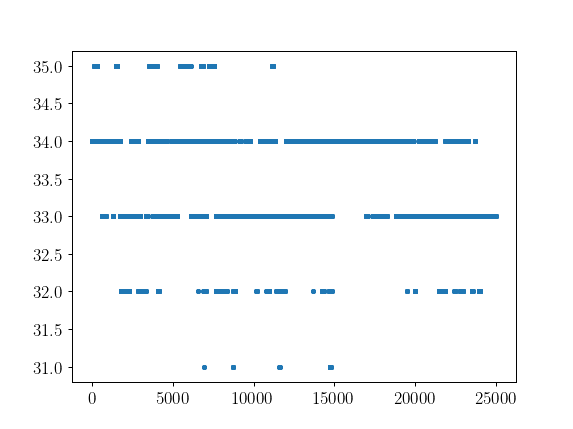

In [68]:
plt.plot([len(states[i]) for i in range(1,Nframes-3)],'.')

## _Low-Pass filters_ 

__butter_lowpass(step,fps, arr) :__ Applies Butterworth low-pass filter to _arr_ array, with averaging width _step_, for a movie with _fps_ frame rate; _fr_ is the fraction of the maximum frequency that is allowed to pass

* Input: _fr_, _step_, _fps_, _arr_; as described above
* Output: RETURNS an array of the same size as _arr_

__cheby1_lowpass(step,fps, arr) :__ Applies Chebyshev type I low-pass filter to _arr_ array, with averaging width _step_, for a movie with _fps_ frame rate

* Input: _step_, _fps_, _arr_; as described above
* Output: RETURNS an array of the same size as _arr_



In [9]:
def butter_lowpass(fr,step,fps, arr):
    
    #N, Wn = signal.buttord(1./(1.*fps/step),1./fps, 1/step, fps*0.5)
    N, Wn = signal.buttord(fr/step, fr, 1/step, fps*0.5 ,0.5/fps)
    b, a = signal.butter(N, Wn,'low')
    yy = signal.filtfilt(b, a, np.squeeze(arr), padtype=None)
    return yy

def filter_tracks_butter(fr,step,fps,tabla):
    tabla_unfiltered = tabla.copy()
    for i in range(Ntracks):
        printp('Filtering positions for track no. ' + str(i+1) + ' of ' + str(Ntracks))
        xbb = np.array(tabla.loc[tabla['track']==i,'x'])
        xb = butter_lowpass(fr,step,info.fps[0], xbb)
        tabla.loc[tabla['track']==i,'x'] = xb
        ybb = tabla.loc[tabla['track']==i,'y']
        yb = butter_lowpass(fr,step,info.fps[0], ybb)
        tabla.loc[tabla['track']==i,'y'] = yb
    print('\n')
    return tabla_unfiltered, tabla

#def cheby1_lowpass(step,fps,arr):
#    N, Wn = signal.cheb1ord(1./(1.*fps/step),1./fps, step, fps*0.5)
#    b, a = signal.cheby1(N, 1./fps, Wn, 'low')
#    y = signal.filtfilt(b, a, arr)
#    return y


## _Get velocities (differences) and accelerations (differences of differences) from individual tracks_

__vels(tabla) :__ Ouputs velocities from tracks table; by decomposing into individual trajectories first

* Input: _tabla_ frame data source

* Output: RETURNS _tabla_ with 2 new columns (_tabla['vx']_, _tabla['vy']_)

In [10]:
def diffs(str01,str02,str1,str2,tabla):
    global last_id
    tabla[str1] = np.zeros(len(tabla))
    tabla[str2] = np.zeros(len(tabla))
    last_id = np.zeros(Ntracks, dtype=int)
    for k in range(Ntracks):
        printp('diffs: ' + str(k+1)+ ' of ' + str(Ntracks) + ' tracks')
        t1 = track(k,tabla,False)
        tabla.loc[t1['index'][:-1],str1] = np.diff(t1[str01])
        tabla.loc[t1['index'][:-1],str2] = np.diff(t1[str02])
        last_id[k] = tabla.loc[tabla['track']==k].index.values[-1:]
    tabla = tabla.drop(last_id)
    print('\n')
    return tabla
    

## Bring data to physical units

We take as coordinate origin the mid-point of the max and min X and Y positions ever tracked within the region of interest (ROI) during the experiment.

We have 2 options for lengh unit: 
* milimeters 
* Ball diameter

The time scale unit is seconds.

Only after this step position differences in the original data table are re-scaled as real velocities

In [11]:
# PHYSICAL SCALES AND ORIGIN
# Usage: re_pos_scale(0) for 1 mm as length unit; re_pos_scale(1) for ball diameter (sigma) 
# length unit

def set_origin(shiftx, shifty, tabla):
    tabla_not_shifted = tabla.copy()
    tabla['x'] -= shiftx
    tabla['y'] -= shifty
    return tabla_not_shifted, tabla

def scale(l_unit, t_unit, tabla):
    global iscaled
    tabla_not_scaled = tabla.copy()
    if iscaled == 0:  
        inv_l_unit = 1./l_unit
        print(inv_l_unit)
        if np.any(tabla.columns=='vx') or np.any(tabla.columns=='vy'):
            print(inv_l_unit)
            tabla[['x','y']] *= inv_l_unit
            tabla[['vx', 'vy']] *= (inv_l_unit * t_unit)
            if np.any(tabla.columns=='ax') or np.any(tabla.columns=='ay'):
                tabla[['ax', 'ay']] *=  (inv_l_unit * t_unit**2)
        else:
            tabla[['x','y']] *= inv_l_unit
        iscaled = 1
    else:
        tabla[['x','y']] *= 1
        iscaled = 0
    return tabla_not_scaled, tabla


## <font color='RED'>RUN CELL 0</font>
### - Import pkl.xz tracks table
### - create all individual tracks arrays
### - analyze track length histogram, decide minimum track length

In [127]:
# COMPLETE SET OF READING INSTRUCTIONS

series_directory = 'ppp/rho_003_019'
hash_prefix = '669933421edfa185664e2821807c10ca'

info = get_info(series_directory, hash_prefix)

datos = simple_pickle_read(series_directory, hash_prefix)
datos_orig, datos = reset_track_indexes(datos)

# Build all tracks, storing them individually
tracks = all_tracks(datos,True)
print('\n min for positions:\n', np.min(datos[['x','y']]), '\n')
print('max. for positions:\n', np.max(datos[['x','y']]), '\n')

,0
experiment_id,669933421edfa185664e2821807c10ca
original_file,D:/serieDensidad 24-07-2019\serieDensidad_N60_p30_1.cine
date,2019-11-13 13:34:19
shape,"[1280, 800]"
fps,250
exposure,1500
n_frames,24981
recording_time,99.924
camera_distance,0.535
pixel_ratio,1950


Number of frames in the movie:  24982
Maximum track index:  454

First 5 rows of imported table:



,frame,track,x,y
0,1,0,655.235978,632.539161
1,1,1,828.993461,58.888198
2,1,2,989.119527,60.599393
3,1,3,712.944364,123.155684
4,1,4,935.532141,129.649911


nothing to fix


 min for positions:
 x    250.000159
y     50.000000
dtype: float64 

max. for positions:
 x    999.999183
y    650.000000
dtype: float64 



<IPython.core.display.Javascript object>


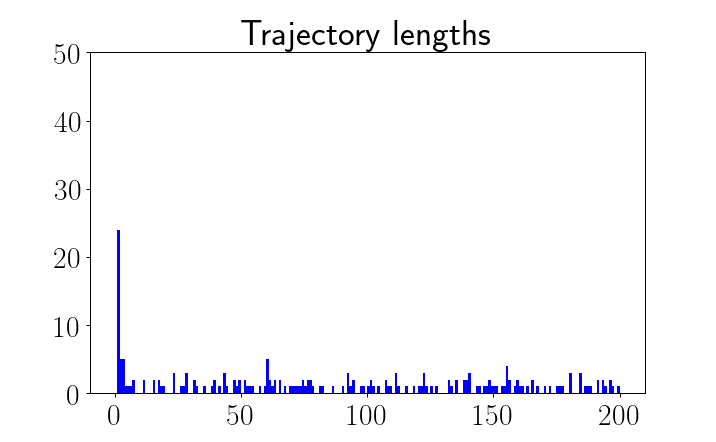

In [128]:
# Histogram of trajectory length
plt.figure(1, figsize=(8,8/ct.golden))
plt.title('Trajectory lengths')
# set upper height limit for histogram
track_lengths = [len(tracks[i]) for i in range(Ntracks)]
plt.ylim(0, 80)
# number of bins for tr4ack length histogram
nbins = 200
#plot
plt.ylim(0,50)
fig=plt.hist( track_lengths, nbins, color='b', range=(0,200))

## <font color='RED'>RUN CELL 1</font>
### - eliminate short tracks
### - obtain position differences  (vels)
### - obtain velocities differences  (accels)
### - create all (non-short) individual tracks arrays. (minimum theoretical length: 5)

In [15]:
tracks_table = [[] for i in range(info.n_frames[0])]

In [129]:
# discard short tracks
ishort = 10 # minimum length of kept tracks
tracks_table[ishort] = short_drop(ishort,datos)
tracks_orig, tracks_table[ishort] = reset_track_indexes(tracks_table[ishort]);
iscaled = 0

# (butterworth)-filter particle positions
tracks_unfiltered, tracks_table[ishort] = \
   filter_tracks_butter(0.8, 4, info.fps[0],tracks_table[ishort]);

# calculate velocities for all tracks
#tracks_table[ishort] = diffs('x','y','vx','vy', tracks_table[ishort]);

#calculate accelerations for all tracks
#tracks_table[ishort] = diffs('vx','vy','ax','ay', tracks_table[ishort]);

# print table head
print('not scaled: \n')
display(HTML( tracks_table[ishort].head().to_html() ))


# scale and re-position the system (left-bottom corner is (0,0))
iscaled=0
not_shifted, tracks_table[ishort] = \
set_origin(np.min(datos.x),np.min(datos.y),tracks_table[ishort]) # re-position

not_scaled, tracks_table[ishort] = \
scale(info.particle_diameter_px[0], 10**3/info.fps[0], tracks_table[ishort]) # scale

# print table head
print('scaled: \n')
display(HTML( tracks_table[ishort].head().to_html() ))


## store tracks individually
#tracks = all_tracks(tracks_table[ishort], True)
#
## store system (instantaneous) states individually
#states = all_states(tracks_table[ishort])



dropped track no. 453; data table length decreased in -7

Dropped out 2 short tracks out of 454

no. of empty track indexes discarded:  36 

Filtering positions for track no. 415 of 415

not scaled: 



,frame,track,x,y
0,1,0,655.371533,632.640777
1,1,1,829.018812,59.015731
2,1,2,989.101346,60.585704
3,1,3,712.898180,123.155295
4,1,4,935.346684,129.538048


0.01282051282051282
scaled: 



,frame,track,x,y
0,1,0,5.197069,7.469754
1,1,1,7.423316,0.115586
2,1,2,9.475656,0.135714
3,1,3,5.934590,0.937888
4,1,4,8.786494,1.019719


In [130]:
tracks_table[ishort].tail()

,frame,track,x,y
714623,24981,397,6.907593,6.895084
714624,24981,403,8.518410,1.373881
714625,24981,405,8.035965,7.442899
714626,24981,412,4.517678,7.074212
714627,24981,413,6.163593,0.589575


<IPython.core.display.Javascript object>


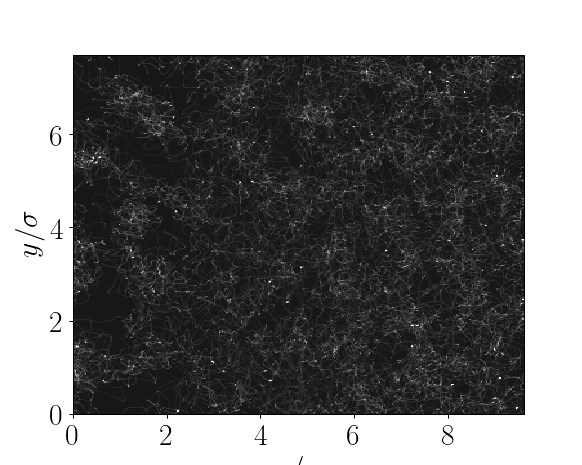

<IPython.core.display.Javascript object>


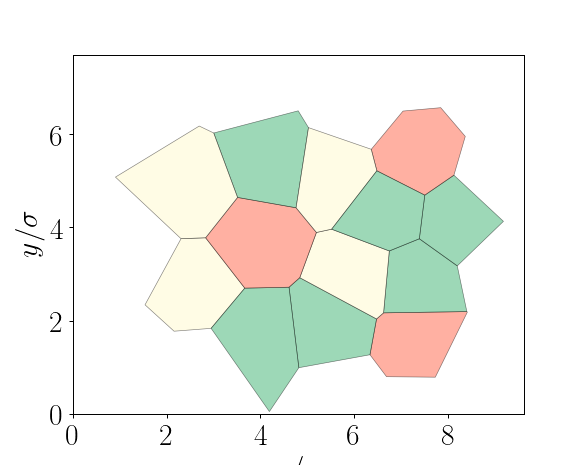

In [132]:
# the scatter plot:
set_up_graf(15, LX, LY)
plt.hist2d(tracks_table[ishort]['x'], tracks_table[ishort]['y'], bins=350, cmap='gray')
plt.clim(-10, 100)

plt.savefig('hist2d_N60_ap30.jpeg', bbox_inches='tight', quality=100)

ss100 = state(100, tracks_table[ishort])
xy = ss100[['x','y']]
npart = len(ss100)

X_off = 0.09 # this is the width of the border layer to discard
Y_off = X_off*0.5

# Make Voronoi graph out of the last particle positions
vor = Voronoi(xy)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LY,Y_off=Y_off)
# Represent particle positions and inner Voronoi cells
set_up_graf(16, LX, LY)
graf = graf_vor(1, 1,inner, LX, LY )

plt.savefig('voronoi_N160_ap30.jpeg', bbox_inches='tight', quality=100)

In [ ]:
plt.hist( np.abs(tracks_table[ishort].vx), 100, color='b');

<IPython.core.display.Javascript object>


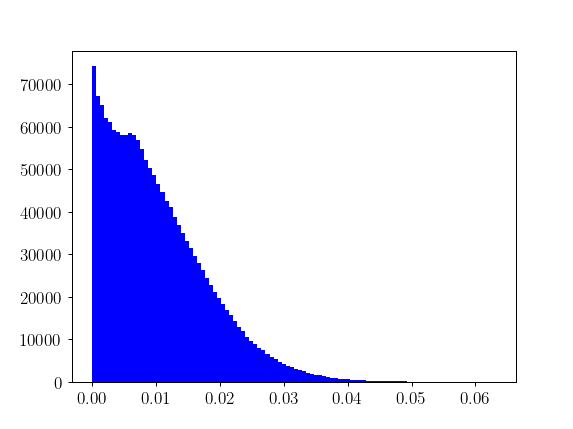

In [16]:
plt.hist( np.abs(tracks_table[ishort].vy), 100, color='b');

## _Average in 'grains'_

__grain(arr, step) :__ Builds coarse-grained trajectories. Designed for noisy trajectories.

* Input: _arr_ array of data to coarse grain; _step_ the coarse-grain size (in time intervals)
* Output: RETURNS a data array

In [7]:
def grain(arr, step):
    invdt = 1./step
    n_arr = len(arr)
    gr_arr = [[i + 0.5*step , (arr[i+step]-arr[i])*invdt] for i in range(0,n_arr-step,step)]
    return np.array(gr_arr)

## _Plotting functions_ 

__frameit(ax):__ frames a figure by drawing the image limits and the ROI limits as well

__plt__\___track(t_id,xs,tagit,fr\_it):__ plots just one track (_t_\__id_) within _fr_\__it_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

__plt__\___tracks(init_id, final_id,xs,tagit,fr\_it):__ plots _init_\__id_ to _final_\__id_ tracks within _fr_\__it_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

In [13]:
def frameit(ax):
    ax.set_xlim(0,info['shape'][0][0])
    ax.set_ylim(0,info['shape'][0][1])
    rect = plt.Rectangle([250,50], 750, 600, alpha=1, lw=10,fill=False, edgecolor='b')
    ax.add_artist(rect)

# Plot just one track function (tagit?, frameit?)
def plt_track(t_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
        
    plt.plot(tracks[t_id].x,tracks[t_id].y, '.', c='r', markersize=px_size,linewidth=None)
    if tagit==True:
        plt.text(np.mean(tracks[t_id].x), np.mean(tracks[t_id].y), str(t_id))
            
def plt_tracks(init_id,final_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
    for i in range(init_id,final_id):
        plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
        if tagit==True:
            plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))

In [15]:
Ntracks

507

In [84]:
# plot just one track, tagit, dont frame it
plt_track(100,7,True,False)

<IPython.core.display.Javascript object>


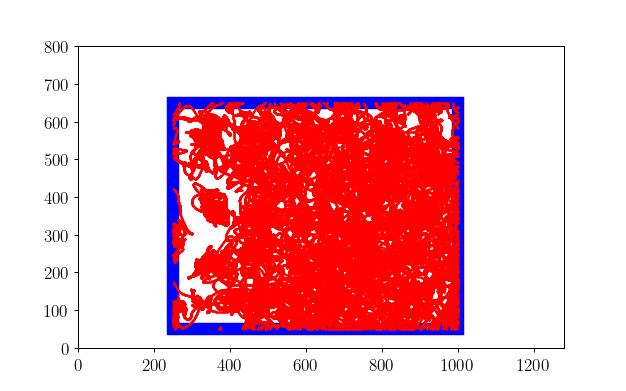

In [16]:
# plot just one track, dont tagit, frame it
plt_tracks(0,Ntracks,7,False, True)

<IPython.core.display.Javascript object>


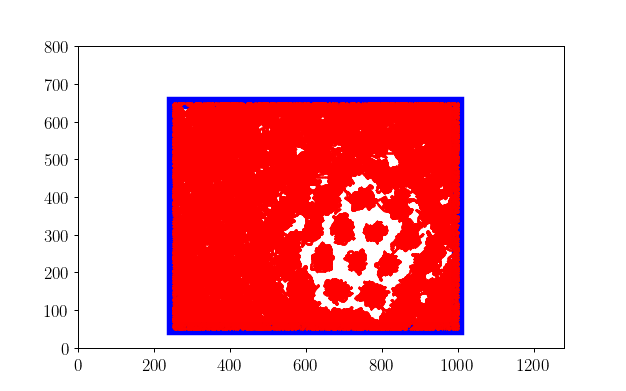

In [184]:
# plot just one track, dont tagit, frame it
plt_tracks(0,Ntracks,7,False, True)

In [33]:
# plot first 40 tracks, tag'em, dont frame them
plt_tracks(0,40,7,True,False)

In [106]:
# same as above, but framed
plt_tracks(0,150,7,True,True)

<IPython.core.display.Javascript object>


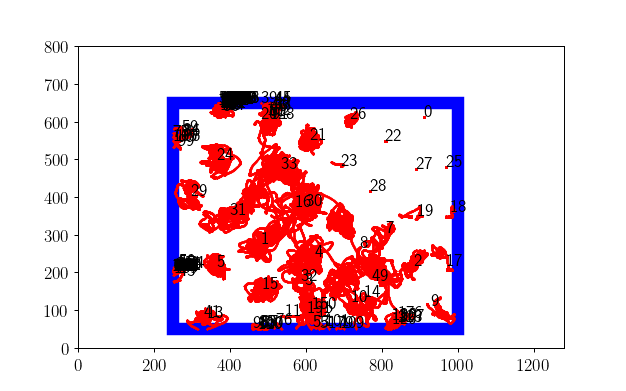

In [22]:
# draw all tracks (notice the tendency towards the right, specially low corner)
plt_tracks(0,Ntracks,7,True,True)

<IPython.core.display.Javascript object>


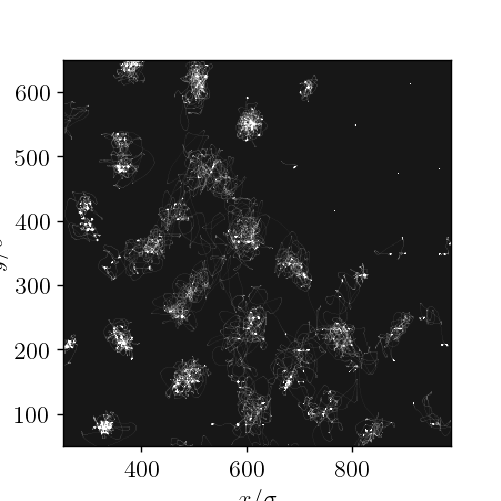

In [30]:
# the scatter plot:
plt.figure(figsize=(4,4),dpi=140)
plt.xlabel(r'$x/\sigma$')
plt.ylabel(r'$y/\sigma$')
plt.xlim(252,1000)
plt.ylim(60,650)
plt.hist2d(tracks_table[ishort]['x'], tracks_table[ishort]['y'], bins=350, cmap='gray')
plt.clim(-10, 100)

In [52]:
plt.savefig('hist2d_N60_ap30.jpeg', bbox_inches='tight', quality=100)

## Static structure functions 

## <font color=crimson>PAIR CORRELATION FUNCTION _g(r)_</font>

In [110]:
6.67*1.e-11*0.11*5.97*1.e24/(3393.5*1.e3)**2

3.803620182449096

In [117]:
(2*np.pi)**2*0.7/1.68**2

9.79127420742992

In [123]:
2.*mp.pi*(0.7/3.80)**0.5

mpf('2.6967276623740135')

In [233]:
# TRUE RADIAL DISTRIBUTION FUNCTION, simple version, no corner corrections

def gr(tabla, nrbin, LX, LY):
    global dr, hist, edges
    # The number of g(r) measurements is the binomial cofficient
    # since the points order in pairs does not matter; i.e., g(ri-rj)=g(rj-ri)
    npart = len(tabla)
    nr_measures = int(spec.binom(npart,2 ))
    #print('measures per bin: ', nr_measures/nrbin) # print no. of measuremnts per bin
    # calculate the bin size, relative to particle radii
    drr = np.sqrt(LX**2 + LY**2)/nrbin
    # initialize array of radial distr function distances array and bin index
    dr = np.zeros(nr_measures)
    ii = 0
    # Loop over all statistically relevant particle pairs
    # calculating distances
    for i in range(npart-1):
        if (i%100==0 and i > 0):
            printp(str(i)+ ' particles performed')
        for j in range(i+1,npart):
            dr[ii] = (tabla.x[i]-tabla.x[j])**2 + (tabla.y[i]- tabla.y[j])**2
            if dr[ii]<78:
                print('careful\n')
            ii = ii +1
    dr = np.sqrt(dr)
    # count number of measured distances per bin; i.e., get the g(r)
    hist, edges = np.histogram(dr,bins=nrbin)
    # create array of bin centers
    r= [edges[i] - 0.5*drr for i in range(len(hist))]
    # normalize the radial distribution function
    g = [ (LX*LY/npart)*hist[i]/(2*np.pi*drr*r[i]) for i in range(len(hist))]
    #r = r[:-1]
    return r, g

In [237]:
r, g = gr(state(50,datos_250), 200, 750,600 )

In [225]:
Nt = int(np.max(datos_250.frame))
gdr = [ np.zeros(100) for i in range(Nt)]

for i in range(1,Nt):
    if (i%100==0 and i > 0):
        printp(str(i)+ ' states performed out of '+str(Nt))
    r, gdr[i] = gr(state(i,datos_250), 100, 750,600 )


24900 states performed out of 24981

In [226]:
g = np.array(gdr[1])
for i in range(2,Nt):
    g = g + np.array(gdr[i])
g = g/(1.0*Nt)

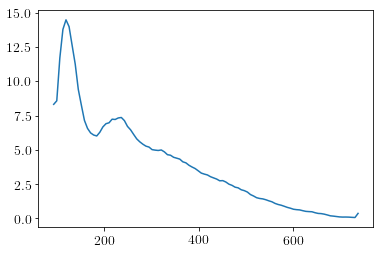

In [227]:
plt.plot(r,g)

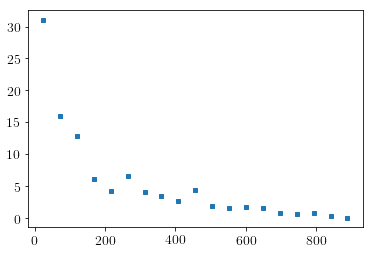

In [150]:
plt.plot(r[:-1],np.array(g),'s',markersize=4)

## VELOCITY AUTOCORRELATIONS

In [17]:
#VELOCITY AUTOCORRELATION functions

# correlations for a track
def vel_autocorr_track(tabla):
    lt = len(tabla)
    vacx = np.empty(lt-1)
    vacy = np.empty(lt-1)
    tvc = np.empty(lt-1)
    for i in range(1,lt-1):
        tvc[i-1] = i
        vacx[i-1] = np.dot(tabla.vx[:-i], tabla.vx[i:])/(lt-i)
        vacy[i-1] = np.dot(tabla.vy[:-i], tabla.vy[i:])/(lt-i)
    return tvc, vacx, vacy

# correlations average for all kept tracks
def vel_autocorr(tabla):
    av_vacx = np.zeros(Nframes-1)
    av_vacy = np.zeros(Nframes-1)
    no_measurmnts = np.zeros(Nframes,dtype=int)
    for i in range(Ntracks):
        tvc, vacx, vacy = vel_autocorr_track(tracks[i])
        av_vacx[:tr_lengths[i]-1] = av_vacx[:tr_lengths[i]-1] + vacx
        av_vacy[:tr_lengths[i]-1] = av_vacy[:tr_lengths[i]-1] + vacy
        no_measurmnts[:tr_lengths[i]] = no_measurmnts[:tr_lengths[i]] + 1
        printp('track ' + str(i) + ' of ' + str(Ntracks))
    for i in range(Nframes-1):
        av_vacx[i] = av_vacx[i]/no_measurmnts[i]
        av_vacy[i] = av_vacy[i]/no_measurmnts[i]
    return av_vacx, av_vacy


In [16]:
tracks = all_tracks(datos_1000)

In [26]:
tvc, vacx, vacy = vel_autocorr_track(tracks[1])

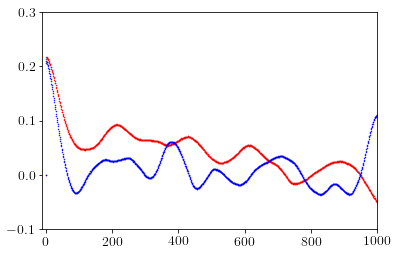

In [28]:
# track10 , datos_2000
fig= plt.figure(1)
px_size = 72./fig.dpi
plt.xlim(-10,1000)
plt.ylim(-0.1,0.3)
plt.scatter(tvc, vacx, marker='.',color='red', s=px_size)
plt.scatter(tvc, vacy, marker='.',color='blue', s=px_size)

## <font color=crimson>BASE $XY$ AND VORONOI FUNCTIONS</font>

In [58]:
LY

600

In [22]:
ss100 = state(100, tracks_table[ishort])

In [23]:
len(ss100)

27

In [59]:

# The 3 previous lines allow for precise input of LX (if LX=LY)
LX = LX/info.particle_diameter_px[0]
LY = LY/info.particle_diameter_px[0]

<IPython.core.display.Javascript object>


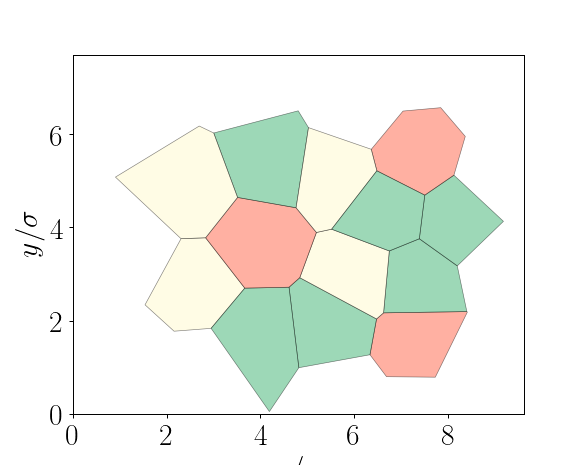

In [60]:
xy = ss100[['x','y']]
npart = len(ss100)

X_off = 0.05 # this is the width of the border layer to discard
Y_off = X_off*0.5

# Make Voronoi graph out of the last particle positions
vor = Voronoi(xy)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LY,Y_off=Y_off)
# Represent particle positions and inner Voronoi cells
set_up_graf(16, LX, LY)
graf = graf_vor(1, 1,inner, LX, LY )

In [35]:
plt.savefig('voronoi_N60_ap30_v2.jpeg', bbox_inches='tight', quality=100)

In [108]:
pwd

'/home/fvega/Codigos/Tracks'

In [75]:
tracks_table[ishort].head()

,frame,track,x,y,vx,vy,ax,ay
0,1,0,48.981407,226.762589,0.202148,0.216288,0.089367,0.066878
1,1,1,315.486156,387.860452,-0.035006,0.055880,-0.004999,0.024505
2,1,2,222.043534,413.796618,-0.008207,-0.239429,-0.052946,-0.045215
3,1,3,142.527806,430.945612,0.091443,0.084343,0.037625,0.043668
4,1,4,3.168695,393.525168,0.025998,-0.034854,0.007982,-0.011431


<IPython.core.display.Javascript object>


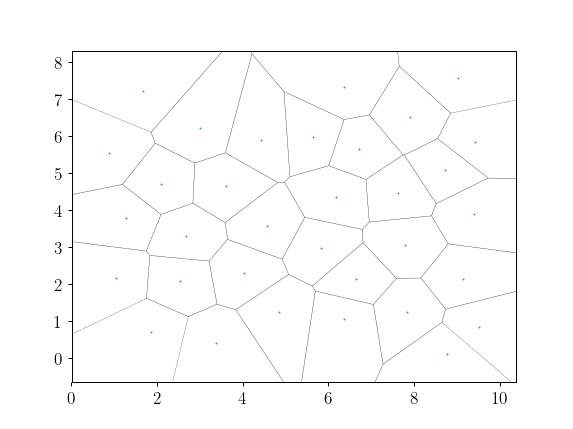

<IPython.core.display.Javascript object>


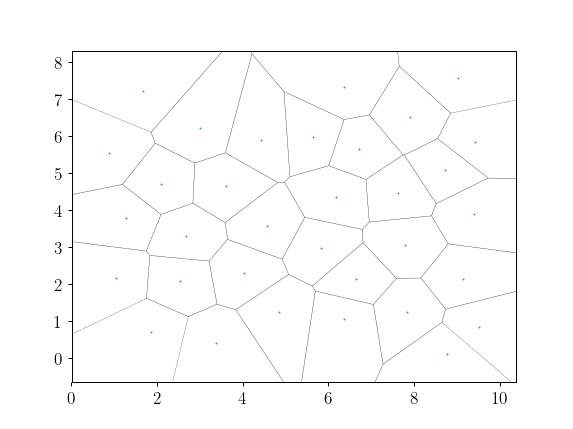

In [159]:
voronoi_plot_2d(vor, point_size=1,show_vertices=False, line_width=0.25)

In [49]:
# all code requires definition of 'npart' 

# READ POSITIONS FROM TEXT FILE generated from MD simulations
def read_xy(path, iframe):
    #nombre = 'hex_test/'+ str(npart)+'/rho0840/accel08/xyz'+ '{0:04d}'.format(iframe) +'.dat'
    nombre = path+'xyz'+ '{0:04d}'.format(iframe) +'.dat'
    # read using numpy:
    # xy = np.loadtxt(nombre, skiprows=1, usecols=(0,1))
    # read using pandas:
    xy = pd.read_table(nombre, skiprows=1, sep = '\s+', header=None,
                        usecols = [0,1], names=['x','y'], index_col=False)
    return xy

def average_xy(path,init_frame, end_frame):
    nframes = end_frame - init_frame + 1
    xy_av = read_xy(path, init_frame)
    for i in range(init_frame+1, end_frame+1):
        xy_av = xy_av + read_xy(path, i)
    xy_av = xy_av / nframes
    return xy_av
        
        
# FILTER OUTER CELLS, returns a numpy array
def inner_xy(xy,LX, X_off, LY, Y_off):
    return list(filter(lambda x: x[0] > X_off and x[1]>Y_off and x[0]<LX-X_off and x[1]<LY-Y_off,
                       [[xy[i][0], xy[i][1]] for i in range(npart)]))

#################################################################################
# Build INNER CELLS list. BEYOND THIS POINT USAGE REQUIRES vor=Voronoi(xy)   ####
#################################################################################


# OBTAINS cell vertices for ONE simulation PARTICLE, but ONLY for INNER cells
# INNER CELL DEFINITION: any cell with none of its vertexes within the border region
# USAGE: pseudo_cell(particle number, x size, x border, y size, y border)
# RETURNS an array of 2D lists (xy vertices positions) if all vertices are inner
# for outer cells returns VOID

def pseudo_cell_xy(vor, p_id, LX, X_off, LY, Y_off):
    b = vor.points[p_id]
    if b[0] < X_off or b[0] > LX-X_off or b[1] < Y_off or b[1] > LY - Y_off:
        c = []
    else:
        c = vor.vertices[vor.regions[vor.point_region[p_id]]]
        if np.any(c.T[0] < X_off) == True or np.any(c.T[0] > LX-X_off) or np.any(c.T[1] < Y_off) == True or np.any(c.T[1] > LY-Y_off):
            c = []
    return c

# OBTAINS THE ENTIRE LIST OF INNER CELLS
# USAGE: inner(particle_simulation_index, vertices_positions_2Dcoords_array)
# RETURNS a numpy array of objects: [particle number, [pseudo_cell_xy] ] with n_inner length
# INPUTS from pseudo_cell_xy, which inputs from Voronoi

def inner_cells(vor, LX, X_off, LY, Y_off):
    global n_inner
    inner = list(filter(lambda x: len(x[1])>3 ,
                          [ [i, pseudo_cell_xy(vor,i, LX, X_off, LY, Y_off)] for i in range(npart)]))
    n_inner = len(inner)
    return inner

#############################################################################################
#############################################################################################

def set_up_graf(idf, LX, LY):
    global ax, fig_system, ss

    fig_system = plt.figure(idf, figsize=(6.5,6.5*LY/LX))
    ss=(72./fig_system.dpi)**2 # particle size
    ax = fig_system.add_subplot(1, 1, 1)
    ax.set_ylim([0,LY])
    ax.set_xlim([0,LX])
    ax.set_xlabel(r'$x/\sigma$',fontsize = 24)
    ax.set_ylabel(r'$y/\sigma$', fontsize = 24)

# TODO: graph simulation snapshot from above, with circles of size = sigma (particle diameter)
def graf_xy(xy, LX, LY):
    graf = ax.scatter(xy.x, xy.y, marker='o', lw=0, s=ss,c='k')

# GRAPHS FOR VORONOI TESSELLATION, only inner cells
# USAGE: graf_vor(inner), with inner a numpy array of inner_cells objects
# RETURNS 2 graphs
# INPUTS FROM inner_cells

def graf_vor(draw_cells, draw_edges, inner, LX, LY):
    
    global fig_cells, polygon_type
    
    # Build polygon type list
    polygon_type = [len(inner[i][1]) for i in range(n_inner)]
            
    # Build color list
    colors_built = ['w' for i in range(n_inner)]
    
    for i in range(len(inner)):
        if len(inner[i][1]) == 4:
            colors_built[i] = 'dodgerblue'
        elif len(inner[i][1]) == 5:
            colors_built[i] = 'mediumseagreen'
        elif len(inner[i][1]) == 6:
            colors_built[i] = 'lemonchiffon'
        elif len(inner[i][1]) == 7:
            colors_built[i] = 'tomato'  
        elif len(inner[i][1]) == 8:
            colors_built[i] = 'pink' 

    # old code
    #fig_cells, ax = plt.subplots(1, num=3, figsize=(9.5,9.5))
        
    # Build colored Tessellation
    # Draw Voronoi polygons
    if draw_cells>0:
        if draw_edges>0:
            lw = 0.5
        else:
            lw = 0
        col = PolyCollection([inner[i][1] for i in range(n_inner)],
                         linewidths=lw, facecolor= colors_built, alpha=0.5)
        col.set_edgecolors('k')
        graf = ax.add_collection(col)

##########################################
### POLYGON TYPE HISTOGRAM ###############
##########################################

    # bar plot the histogram
    #fig_hist, ax0 = plt.subplots(1, num=1, figsize=(7,7/ct.golden))
    
            
    # build distr. f of polygons
    #sides_distr = np.histogram(polygon_type, bins =np.arange(3,15) )
    #    
    #plt.xlim(np.min(polygon_type)-1,np.max(polygon_type)+1)
    #plt.ylim(0, 1.1*np.max(sides_distr[0]))
    #
    #plt.ylabel('$N$')
    #plt.xlabel('polygon')   

    ## Compute & Display ratio of hexagons
    #hex_ratio = sides_distr[0][3]/(1.*n_inner)
    ## define text box
    #plt.text(3.25, 1.0*np.max(sides_distr[0]), 'hexagons (\%): ' + '{:.2%}'.format(hex_ratio),
    #         size=12, ha="left", va="center",
    #         bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),)
    #         )
  
    #plt.bar(sides_distr[1][:-1], height=sides_distr[0], align='center')
    
##########################################


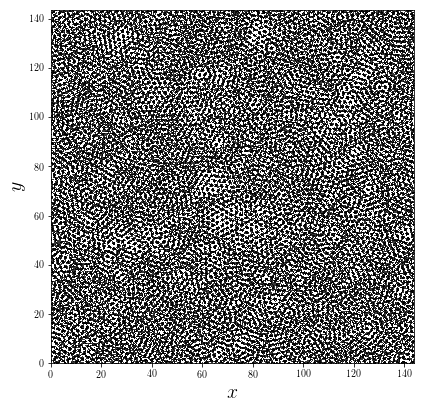

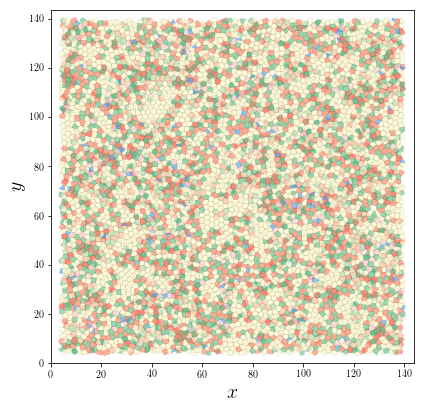

In [7]:
# CODIGO DE EJECUCION TESELACION DE VORONOI + GRAFICAS

base_path = '/home/fvega/Codigos/MD/hex_test/5000/rho0840/'
#base_path = '/home/fvega/Documentos/Apuntes/air_fluidized_exps/datos/'
#extra_path = 'hex_test/' + str(npart) + '/'
extra_path = 'accel1350/'

path = base_path + extra_path 

density = 0.840
npart = 5000
#xy = av_xy(800,990)
LX = L(npart, density) 
LY = LX

# The 3 previous lines allow for precise input of LX (if LX=LY)
X_off = 3 # this is the width of the border layer to discard
Y_off = X_off

#del fig_cells
set_up_graf(5, LX, LY)
for i in range(40):
    xy = read_xy(path, 950+i)
    grafxy = graf_xy(xy, LX, LY)

# Make Voronoi graph out of the last particle positions
vor = Voronoi(xy)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LX,Y_off=X_off)
# Represent particle positions and inner Voronoi cells
set_up_graf(6, LX, LY)
graf = graf_vor(1, 1,inner, LX, LX )

xy_av = average_xy(path,950,999)

# Make Voronoi graph out of average particle positions
vor = Voronoi(xy_av)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LX,Y_off=X_off)

# Superimpose 
graf = graf_vor(1, 1,inner, LX, LX )

In [ ]:
%%time

nrbin = 10000
r, g = gr(nrbin)
plt.plot(r, g, 'bo', markersize=0.6125)
plt.figure()
plt.xlim(0,20)
plt.plot(r, g, 'bo', markersize=1.25)

In [ ]:
#####################################################
######### XY 2D-STRUCTURE BASE FUNCTIONS  ###########
#####################################################
# return 2D XY-bin size (dxbin, dybin)
def make_xy_bins(nxbin, nybin):
    global dxbin, dybin, rmax
    # set init BINS MATRIX
    rho = np.zeros((nxbin,nybin))
    dxbin = (LX-2*X_off)/nxbin
    dybin = (LY-2*Y_off)/nybin
    rmax = np.sqrt((nxbin*dxbin)**2 + (nybin*dybin)**2)


#####################################################
######### RADIAL STRUCTURE BASE FUNCTIONS ###########
#####################################################
# returns r-bin size (drbin)
def make_r_bins( nrbin):
    global drbin
    rho_r = np.zeros(nrbin)
    drbin = rmax/(1.0*nrbin)

    
#########################################################################
################       XY BINS FUNCTIONS            #####################
#########################################################################
# returns ixy 2D index for a particle position. used by rho
def get_particle_xy_bin(pos_xy, nxbin, nybin):
    global ii
    ii = np.zeros(2, dtype=int)
    ii[0] = int(np.floor((pos_xy[0]-X_off)/dxbin))
    ii[1] = int(np.floor((pos_xy[1]-Y_off)/dybin)) #outer particles have negative index
    if ii[0] < 0 or ii[0] >= nxbin or ii[1] < 0 or ii[1] >= nybin:
        ii[0] = -1; ii[1] = -1

# return XY particle bins: ixy[i] variable, 'i' being 
# loop only over inner particles
def rho_xy(npart, nxbin, nybin):
    global ixy, nxy
    #npart = len(xy)
    ixy = np.zeros((npart,2), dtype=int)
    nxy = np.zeros((nxbin, nybin), dtype=int)
    for i in range(npart):
        get_particle_xy_bin(xy.ix[i], nxbin, nybin)
        ixy[i] = (ii[0], ii[1]) # identify the xy bin
        if ii[0] >= 0 and ii[1] >= 0:
            nxy[ii[0]][ii[1]] = nxy[ii[0]][ii[1]] + 1 # xy bin population sum

#########################################################################
################            RADIAL BIN FUNCTIONS          ###############
#########################################################################
# XY BIN DISTANCE FUNCTION: obtains distance between square bins
# input: first xy bin, second xy bin (2 pairs of integer numbers)
def bd(ij, ijprime):
    return np.sqrt(((ij[0]-ijprime[0])*dxbin)**2 + ((ij[1]-ijprime[1])*dybin)**2)


# Obtain all r bins
# Relies on bin-distance function (bd)
# ij is the reference bin
def get_r_bin(ij, ijprime):
    global rbin
    rbin = int( np.floor(bd(ij, ijprime)/drbin))
    return int(rbin)

# counts the number of times (ahead) we find an r-bin in the xy matrix
# it aims to naturally normalize radial functions according to this number
# r-bins counts stored in:  #### nir[rbin]  ####
def r_bin_counts(nxbin, nybin, nrbin):
    global nir, rij
    # rij: variable storing the r-bin for each xy-bin pair 
    rij = np.zeros((nxbin, nybin, nxbin, nybin))
    # nir: variable storing the number of occurrences for each r-bin
    # it is used for normalization in r-functions
    nir = np.zeros(nrbin+1, dtype=int)
    snxbin = str(nxbin)
    for i in range(nxbin):
        for j in range(nybin):
            for jp in range(j+1,nybin): # if pair in the same row, just count cells ahead
                rij[i, j, i, jp] = get_r_bin((i, j), (i, jp))
                nir[rbin] = nir[rbin] + 1
            for ip in range(i+1,nxbin):
                for jp in range(nybin):
                    rij[i, j, ip, jp] = get_r_bin((i, j), (ip, jp))
                    nir[rbin] = nir[rbin] + 1
        printp('line ' + str(i+1) + ' of ' + snxbin + ' complete')
    if nir[0] == 0: 
        print('r-bin size too small, choose less r-bins')
        
# RADIAL DENSITY FUNCTION
# procedure is as follows:
# we iterate over xy-bins, which are in each case the density origin (rho(0))
# for each xy-bin, we iterate over the following bins in the matrix, 
# and update rho according to the total population of the iteration bin
# and its distance to current origin
def rho_r(nxbin, nybin, nrbin ):
    global rho, rho_p
    rho = np.zeros(nrbin)
    for i in range(nxbin):
        for j in range(nybin):
            for jp in range(j+1,nybin): # if pair in the same row, just count cells ahead
                rbin = int(rij[i, j, i, jp])
                #print(rbin)
                rho[rbin] = rho[rbin] + nxy[i,jp]
            for ip in range(i+1,nxbin):
                for jp in range(nybin):
                    rbin = int(rij[i, j, ip, jp])
                    rho[rbin] = rho[rbin] + nxy[ip,jp]

    # normalize density
    for i in range(nrbin):
        rho[i] = rho[i]/nir[i]


In [ ]:
################################
# Build NEIGHBORS LIST #########
################################
def neighbor_cells(iframe):
    Voronoi_inner(iframe)
    neighbors = [[] for i in range(npart)]
    print('no. of inner particles: ', n_inner)
    for k in range(n_inner):
        part = inner[k][0]
        # cn: coordination no. of current particle (= the number of vertices in its cell)
        cn = len(vor.regions[vor.point_region[part]])
        # list of vertices for current particle
        verts = vor.regions[vor.point_region[part]]
        # initialize list  (raw_neighbors) of lists (raw_neighbors[i])
        # sublists will end up being the list of vertices in the cell of the repeated vertex
        raw_neighbors = [[] for i in range(cn)]
    
        # for each vertex, search its repetitions in the other cells, but only in inner ones
        for j in range(cn):
            # a closest neighbor is defined as a particle that has a common a cell vertex with the ref. part.
            raw_neighbors[j]=list(filter(lambda x: any(np.array(vor.regions[vor.point_region[x]]) == verts[j])
                                     , [inner[i][0] for i in range(n_inner)] ))
        # (each raw_neighbors is now the list of particles whose cell contains current vertex)
    
        # collapse into a single list
        for j in range(1,cn):
            raw_neighbors[0]+=raw_neighbors[j]
        # filter out self-repetitions
        raw_neighbors[0]= list(filter(lambda x: x != part, raw_neighbors[0]))
        # remove duplicates from shared vertices among neighbor cells (set) and sort (sorted)  
        neighbors[part] = sorted(np.array(list(set(raw_neighbors[0]))))
        if k%100==0: printp('iteracion: ' + str(k))


In [ ]:
# ORIENTATIONAL CORRELATION FUNCTION


psi = np.zeros((nxbin, nybin)) # initialize psi matrix

for i in range(len(inner)):
    part = inner[i][0]
    icn = 1./len(neighbors[part]) 
    xyk = vor.points[part]
    rk = np.linalg.norm(xyk)
    
    xbin = int(np.floor(xyk[0]/dbin))
    ybin = int(np.floor(xyk[1]/dbin))
    
    # k is the reference particle, j is the neighbor
    for j in range(cn):
        xyj = vor.points[neighbors[part][j]]
        rj= np.linalg.norm(xyj)
        thetajk = np.arccos(np.dot(xyk,xyj)/(rj*rk))
        psi[xbin][ybin] += (np.exp(thetajk*6j)*icn)